## 1. Setup & Environment
Mount Google Drive and import required packages.

In [ ]:
!git clone https://github.com/hillasch/SPICE-model.git
%cd SPICE-model
!git checkout hilla
!git pull


fatal: destination path 'SPICE-model' already exists and is not an empty directory.
/content/SPICE-model
Already on 'hilla'
Your branch is up to date with 'origin/hilla'.
Already up to date.


In [ ]:
%cd /content/SPICE-model


/content/SPICE-model


In [ ]:
!ls


artifacts  image-transcreation	pro_deep.py  test.py


In [ ]:
%cd /content/SPICE-model
!git status


/content/SPICE-model
On branch hilla
Your branch is up to date with 'origin/hilla'.

nothing to commit, working tree clean


In [ ]:
# Setup
import os
from pathlib import Path

print("CWD:", Path.cwd())
!git status


CWD: /content/SPICE-model
On branch hilla
Your branch is up to date with 'origin/hilla'.

nothing to commit, working tree clean


In [ ]:
%cd /content
!mkdir -p datasets
%cd /content/datasets
!git clone https://github.com/simran-khanuja/image-transcreation.git


/content
/content/datasets
fatal: destination path 'image-transcreation' already exists and is not an empty directory.


In [ ]:
# relevant imports
from __future__ import annotations
!pip -q install pillow matplotlib
import argparse
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from typing import Dict, Optional
from urllib.parse import unquote

import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

try:
    from tqdm import tqdm
except ImportError:  # Fallback when tqdm is not installed
    def tqdm(iterable=None, total=None):
        return iterable
import subprocess
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DRIVE_DATASET_DIR = Path("/content/drive/MyDrive/transcreation_dataset")
DRIVE_DATASET_DIR


PosixPath('/content/drive/MyDrive/transcreation_dataset')

In [ ]:
from pathlib import Path

# --- Code repository (yours) ---
CODE_DIR = Path("/content/SPICE-model")

# --- Dataset repository (theirs, not tracked by git) ---
DATA_REPO_DIR = Path("/content/datasets/image-transcreation")
DATA_REPO_DIR.exists(), DATA_REPO_DIR

# --- Artifacts generated by your code (CSV, images, etc.) ---
ARTIFACTS_DIR = CODE_DIR / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True)

DEFAULT_OUTPUT_CSV = ARTIFACTS_DIR / "final_dataset_clean.csv"
DEFAULT_IMAGES_DIR = ARTIFACTS_DIR / "images"
DEFAULT_IMAGES_DIR.mkdir(exist_ok=True)

DEFAULT_MAX_WORKERS = 10


## 2. Load & Prepare Metadata
Load raw metadata, clean it, and keep only the required columns.


In [ ]:
from urllib.parse import unquote

def norm_path_or_url(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    return unquote(str(x)).strip()

In [ ]:
from pathlib import Path
import pandas as pd


def resolve_repo_path(repo_dir: Path, p: str) -> str:
    """Convert a repo-relative path to an absolute path (string)."""
    if p is None or (isinstance(p, float) and pd.isna(p)):
        return None
    p = str(p)
    # if already absolute
    if p.startswith("/") or (len(p) > 1 and p[1] == ":"):
        return p
    # repo-relative
    return str((repo_dir / p).resolve())


In [ ]:
from pathlib import Path

def load_all_metadata(repo_dir: Path, part: str) -> pd.DataFrame:
    meta_root = repo_dir / "outputs" / part / "caption-llm_edit"
    files = list(meta_root.glob("*/metadata.csv"))
    rows = []
    for f in files:
        target_country = f.parent.name
        df = pd.read_csv(f)
        df.columns = df.columns.str.strip()
        df["target_country"] = target_country
        df["src_image_path"] = df["src_image_path"].apply(norm_path_or_url)
        df["src_key"] = df["src_image_path"]  # key = full normalized URL

        rows.append(df)

    meta = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

    # חשוב: למנוע כפילויות במטא
    if not meta.empty:
        meta = meta.drop_duplicates(subset=["target_country", "src_key"])

    return meta


In [ ]:
def load_all_splits(repo_dir: Path, part: str) -> pd.DataFrame:
    root = repo_dir / "outputs" / part / "all_images"
    files = list(root.rglob("split_*.csv"))
    rows = []
    for f in files:
        target_country = f.parent.name
        df = pd.read_csv(f)
        df.columns = df.columns.str.strip()
        if "src_image_path" not in df.columns or "model_path_2" not in df.columns:
            continue

        df["target_country"] = target_country
        df["src_image_path"] = df["src_image_path"].apply(norm_path_or_url)
        df["src_key"] = df["src_image_path"]
        df["split_file"] = f.name

        rows.append(df[["target_country", "src_image_path", "src_key", "model_path_2", "split_file"]])

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()


In [ ]:
def build_final_df(repo_dir: Path) -> pd.DataFrame:
    all_parts = []
    for part in ["part1", "part2"]:
        meta = load_all_metadata(repo_dir, part)
        outs = load_all_splits(repo_dir, part)

        merged = outs.merge(
            meta[["target_country", "src_key", "src_country", "caption", "llm_edit"]],
            on=["target_country", "src_key"],
            how="inner",
            validate="many_to_one",
        )

        merged["part"] = part

        merged = merged[[
            "part",
            "src_image_path",      # מגיע מ-outs, נשאר בשם הזה ✅
            "src_country",
            "target_country",
            "caption",
            "llm_edit",
            "model_path_2",
            "split_file",
        ]]

        all_parts.append(merged)

    return pd.concat(all_parts, ignore_index=True)


In [ ]:
final_df = build_final_df(DATA_REPO_DIR)
print(final_df.shape)
final_df.head()



(4256, 8)


,part,src_image_path,src_country,target_country,caption,llm_edit,model_path_2,split_file
0,part1,https://storage.googleapis.com/image-transcrea...,united-states,nigeria,a large black bear standing in the woods,a big black bear standing in the bush,https://storage.googleapis.com/image-transcrea...,split_4.csv
1,part1,https://storage.googleapis.com/image-transcrea...,india,nigeria,a large field of cotton is shown in this picture,A vast expanse of cotton is depicted in this p...,https://storage.googleapis.com/image-transcrea...,split_4.csv
2,part1,https://storage.googleapis.com/image-transcrea...,portugal,nigeria,a group of people standing in front of a small...,a group of people gathered in front of a bungalow,https://storage.googleapis.com/image-transcrea...,split_4.csv
3,part1,https://storage.googleapis.com/image-transcrea...,portugal,nigeria,two oranges and a white flower on a tree,two oranges and a white hibiscus on a mango tree,https://storage.googleapis.com/image-transcrea...,split_4.csv
4,part1,https://storage.googleapis.com/image-transcrea...,turkey,nigeria,a person holding a green cucumber on a plant,a person holding a ripe okra on a farm in Nigeria,https://storage.googleapis.com/image-transcrea...,split_4.csv


## 3. Dataset Sanity Check

Images are downloaded locally for training.
Only samples for which **both source and target images were successfully downloaded**
are kept in the final training dataset.


In [ ]:
final_df.shape


(4256, 8)

In [ ]:
final_df.isna().mean().sort_values(ascending=False).head(10)


,0
part,0.0
src_image_path,0.0
src_country,0.0
target_country,0.0
caption,0.0
llm_edit,0.0
model_path_2,0.0
split_file,0.0


## 4. Duplicate Check Across Splits

We analyzed duplicate occurrences by grouping the data by  
`part`, `target_country`, and `src_image_path`.

Most combinations appear only once, while a subset appears multiple times due to
the same source image–target country pair being evaluated across different splits.
Specifically, some instances appear two to four times.


In [ ]:
final_df.duplicated(subset=["part","target_country","src_image_path"]).mean()


np.float64(0.0)

We see that we have duplicates between splits.
which is rational but for the train we only need one of each

In [ ]:
final_df.groupby(
    ["part", "target_country", "src_image_path"]
).size().value_counts().head()


,count
1,4256


These duplicates are expected and reflect the dataset’s split-based evaluation setup,
rather than data leakage or incorrect preprocessing.  
For training purposes, we keep a single representative instance per  
`(part, target_country, src_image_path)` combination, removing split-level redundancy.


## 5. Dataset Filtering
We remove duplicated samples that appear across the provided splits and retain only
rows with valid downloaded source–target image pairs.

In [ ]:
final_df_clean = (
    final_df
    .sort_values("split_file")  # בחירה דטרמיניסטית
    .drop_duplicates(
        subset=["part", "target_country", "src_image_path"],
        keep="first"
    )
    .reset_index(drop=True)
)

print("Before:", len(final_df))
print("After :", len(final_df_clean))


Before: 4256
After : 4256


In [ ]:
pair_check = (
    final_df_clean
    .groupby(["src_image_path", "target_country"])["caption"]
    .nunique()
    .reset_index(name="n_captions")
)

pair_check[pair_check["n_captions"] > 1].head()



,src_image_path,target_country,n_captions


In [ ]:
final_df_clean.groupby("src_image_path")["target_country"].nunique().describe()


,target_country
count,695.000000
mean,6.123741
std,0.385916
min,4.000000
25%,6.000000
50%,6.000000
75%,6.000000
max,7.000000


In [ ]:
final_df_clean.sample(5)[
    ["src_image_path", "model_path_2", "caption", "target_country", "split_file"]
]


,src_image_path,model_path_2,caption,target_country,split_file
2684,https://storage.googleapis.com/image-transcrea...,https://storage.googleapis.com/image-transcrea...,a woman wearing a white dress and pink leggings,japan,split_3.csv
469,https://storage.googleapis.com/image-transcrea...,https://storage.googleapis.com/image-transcrea...,a large building with a dome in the middle of ...,united-states,split_1.csv
2113,https://storage.googleapis.com/image-transcrea...,https://storage.googleapis.com/image-transcrea...,a large building lit up at night in a park,portugal,split_2.csv
1600,https://storage.googleapis.com/image-transcrea...,https://storage.googleapis.com/image-transcrea...,a group of colorful houses on stilts in the water,india,split_2.csv
993,https://storage.googleapis.com/image-transcrea...,https://storage.googleapis.com/image-transcrea...,a cartoon illustration of a man talking on the...,brazil,split_1.csv


In [ ]:
from pathlib import Path
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import textwrap


def show_dataset_samples(
    csv_path: Path,
    samples_to_show: int = 3,
    seed: int = 42,
) -> None:
    """Display random source/target image pairs for a quick visual sanity check."""
    csv_path = Path(csv_path)

    if not csv_path.exists():
        print(f"CSV file not found at {csv_path}")
        return

    df = pd.read_csv(csv_path)

    required_cols = {
        "src_image_path",
        "model_path_2",
        "target_country",
    }
    missing = required_cols - set(df.columns)
    if missing:
        print(f"CSV is missing required columns: {sorted(missing)}")
        return

    # Only keep rows with both images
    df_complete = df[
        df["src_image_path"].notna() & df["model_path_2"].notna()
    ].copy()

    if df_complete.empty:
        print("No complete (source + target) image pairs found.")
        return

    n = min(samples_to_show, len(df_complete))
    samples = df_complete.sample(n=n, random_state=seed)

    print(f"Displaying {n} samples out of {len(df_complete)} valid pairs...")

    for _, row in samples.iterrows():
        src_path = Path(row["src_image_path"])
        tgt_path = Path(row["model_path_2"])

        if not src_path.exists() or not tgt_path.exists():
            print("Skipping row with missing image files")
            continue

        try:
            img_src = Image.open(src_path).convert("RGB")
            img_tgt = Image.open(tgt_path).convert("RGB")

            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            axes[0].imshow(img_src)
            axes[0].set_title(
                f"Source ({row.get('src_country', 'N/A')})",
                fontsize=10,
            )
            axes[0].axis("off")

            axes[1].imshow(img_tgt)
            axes[1].set_title(
                f"Target ({row.get('target_country', 'N/A')})",
                fontsize=10,
                color="blue",
                fontweight="bold",
            )
            axes[1].axis("off")

            edit_text = row.get("llm_edit", "No instruction")
            wrapped_text = "\n".join(textwrap.wrap(f"Instruction: {edit_text}", width=80))
            fig.suptitle(wrapped_text, fontsize=12, y=1.05)

            fig.tight_layout()
            plt.show()
            plt.close(fig)
            print("-" * 80)

        except Exception as exc:
            print(f"Error displaying images: {exc}")


In [ ]:
# Save metadata (URLs, captions, etc.)

DRIVE_DATASET_DIR = Path("/content/drive/MyDrive/transcreation_dataset")
DRIVE_DATASET_DIR.mkdir(parents=True, exist_ok=True)

metadata_csv = DRIVE_DATASET_DIR / "metadata.csv"
final_df_clean.to_csv(metadata_csv, index=False)
print(f"Saved metadata to {metadata_csv}")


Saved metadata to /content/drive/MyDrive/transcreation_dataset/metadata.csv


In [ ]:
import os
from pathlib import Path
from urllib.parse import urlparse
import pandas as pd
import requests
from tqdm import tqdm


def _safe_filename(s: str) -> str:
    # makes a safe-ish filename from URL or path
    s = str(s)
    base = os.path.basename(urlparse(s).path) or "image"
    base = base.split("?")[0]
    return base


def download_image(url: str, out_path: Path, timeout: int = 20, retries: int = 2) -> bool:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.exists() and out_path.stat().st_size > 0:
        return True

    for _ in range(retries + 1):
        try:
            r = requests.get(url, stream=True, timeout=timeout)
            r.raise_for_status()
            with open(out_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=1024 * 128):
                    if chunk:
                        f.write(chunk)
            return out_path.exists() and out_path.stat().st_size > 0
        except Exception:
            continue

    return False


def materialize_local_paths(
    df: pd.DataFrame,
    src_col: str = "src_image_path",
    tgt_col: str = "model_path_2",
    base_dir: Path = Path("/content/images"),
    max_rows: int | None = None,
) -> pd.DataFrame:
    """
    Download source/target images locally and add src_local_path/target_local_path.
    Keeps only rows where both downloads succeeded.
    """
    work = df.copy()
    if max_rows is not None:
        work = work.head(max_rows).copy()

    src_dir = base_dir / "src"
    tgt_dir = base_dir / "target"

    src_local = []
    tgt_local = []
    ok_mask = []

    for _, row in tqdm(work.iterrows(), total=len(work)):
        src = row.get(src_col)
        tgt = row.get(tgt_col)

        if pd.isna(src) or pd.isna(tgt):
            src_local.append(None)
            tgt_local.append(None)
            ok_mask.append(False)
            continue

        # build filenames (optionally include target_country to avoid collisions)
        country = str(row.get("target_country", "NA"))
        src_name = f"{country}__src__{_safe_filename(src)}"
        tgt_name = f"{country}__tgt__{_safe_filename(tgt)}"

        src_path = src_dir / src_name
        tgt_path = tgt_dir / tgt_name

        src_ok = download_image(str(src), src_path)
        tgt_ok = download_image(str(tgt), tgt_path)

        src_local.append(str(src_path) if src_ok else None)
        tgt_local.append(str(tgt_path) if tgt_ok else None)
        ok_mask.append(bool(src_ok and tgt_ok))

    work["src_local_path"] = src_local
    work["target_local_path"] = tgt_local

    work_ok = work[pd.Series(ok_mask, index=work.index)].copy()
    print(f"Kept {len(work_ok)}/{len(work)} rows with both images downloaded.")
    return work_ok


In [ ]:
import shutil
images_dir = DRIVE_DATASET_DIR / "images"
shutil.rmtree(images_dir, ignore_errors=True)
(images_dir / "src").mkdir(parents=True, exist_ok=True)
(images_dir / "target").mkdir(parents=True, exist_ok=True)

df_train = materialize_local_paths(
    final_df_clean,
    base_dir=images_dir
)


100%|██████████| 4256/4256 [17:34<00:00,  4.04it/s]

Kept 4255/4256 rows with both images downloaded.


In [ ]:
train_csv = DRIVE_DATASET_DIR / "train_dataset.csv"
df_train.to_csv(train_csv, index=False)
print(f"Saved training dataset to {train_csv}")


Saved training dataset to /content/drive/MyDrive/transcreation_dataset/train_dataset.csv


In [ ]:
from pathlib import Path
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import textwrap


def show_dataset_samples_local(
    csv_path: Path,
    samples_to_show: int = 3,
    seed: int = 42,
) -> None:
    csv_path = Path(csv_path)

    if not csv_path.exists():
        print(f"CSV file not found at {csv_path}")
        return

    df = pd.read_csv(csv_path)

    required_cols = {"src_local_path", "target_local_path"}
    missing = required_cols - set(df.columns)
    if missing:
        print(f"CSV is missing required columns: {sorted(missing)}")
        return

    df = df.dropna(subset=["src_local_path", "target_local_path"])
    if df.empty:
        print("No valid local image pairs found.")
        return

    samples = df.sample(n=min(samples_to_show, len(df)), random_state=seed)

    print(f"Displaying {len(samples)} samples out of {len(df)} local pairs...")

    for idx, row in samples.iterrows():
        print(f"IDX = {idx}")
        src_path = Path(row["src_local_path"])
        tgt_path = Path(row["target_local_path"])

        if not src_path.exists() or not tgt_path.exists():
            print("Skipping missing local files")
            continue

        img_src = Image.open(src_path).convert("RGB")
        img_tgt = Image.open(tgt_path).convert("RGB")

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].imshow(img_src)
        axes[0].set_title(f"Source ({row.get('src_country', 'N/A')})")
        axes[0].axis("off")

        axes[1].imshow(img_tgt)
        axes[1].set_title(f"Target ({row.get('target_country', 'N/A')})", color="blue")
        axes[1].axis("off")

        instruction = row.get("llm_edit", "No instruction")
        wrapped = "\n".join(textwrap.wrap(instruction, width=80))
        fig.suptitle(wrapped, fontsize=12)

        plt.tight_layout()
        plt.show()
        plt.close(fig)

        print("-" * 80)



Displaying 2 samples out of 4255 local pairs...
IDX = 184


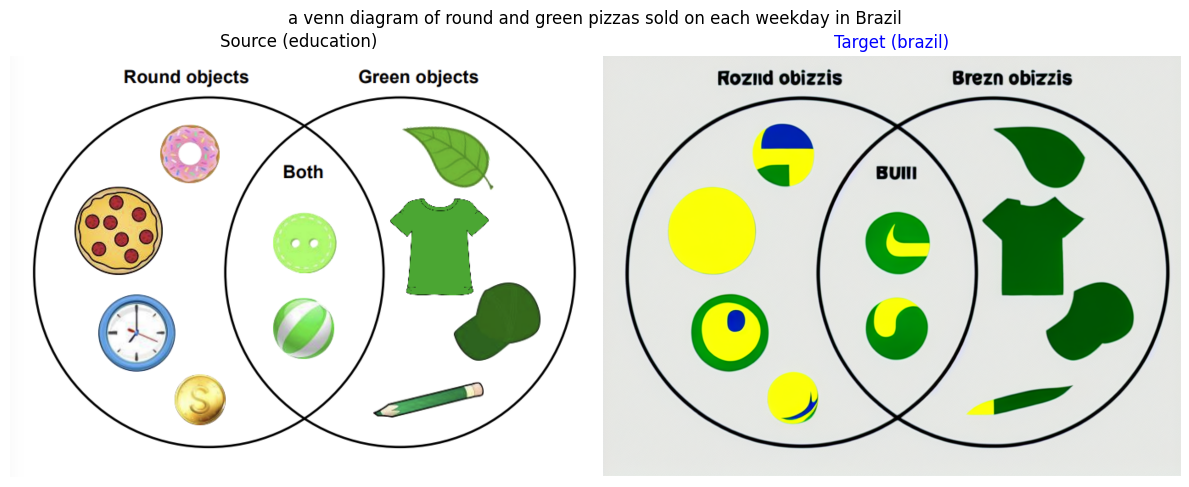

--------------------------------------------------------------------------------
IDX = 1018


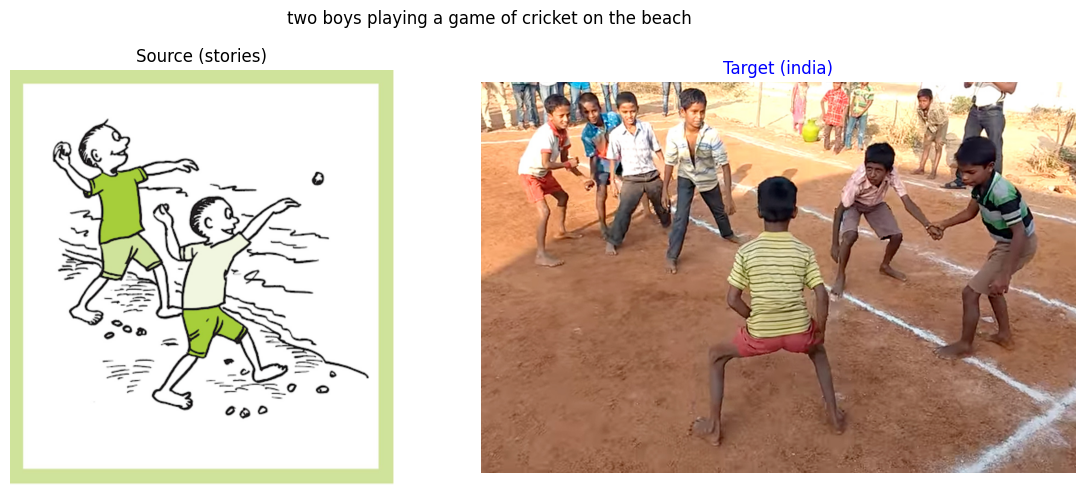

--------------------------------------------------------------------------------


In [ ]:
show_dataset_samples_local(
    csv_path=train_csv,
    samples_to_show=2
)



In [ ]:
def get_device():
    """Return the best available torch device (lazy import to avoid hard dependency)."""
    import torch
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

def get_frozen_model(device=None, model_name="facebook/dinov2-base"):
    """Load and freeze a pretrained DINOv2 model for feature extraction."""
    import os
    import torch
    from transformers import AutoImageProcessor, AutoModel

    device = device or get_device()

    # Optional: Colab-friendly cache (prevents repeated downloads)
    os.environ.setdefault("HF_HOME", "/content/hf_cache")
    os.environ.setdefault("TRANSFORMERS_CACHE", "/content/hf_cache")

    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)

    model.eval()  # important: inference behavior
    for p in model.parameters():
        p.requires_grad = False  # freeze

    return processor, model, device

In [ ]:
def load_text_encoder(device=None, model_name="openai/clip-vit-base-patch32"):
    """Load and freeze the CLIP text encoder."""
    import os
    import torch
    from transformers import CLIPTextModel, CLIPTokenizer

    device = device or get_device()

    # Optional: Colab-friendly cache
    os.environ.setdefault("HF_HOME", "/content/hf_cache")
    os.environ.setdefault("TRANSFORMERS_CACHE", "/content/hf_cache")

    tokenizer = CLIPTokenizer.from_pretrained(model_name)
    text_encoder = CLIPTextModel.from_pretrained(model_name).to(device)

    text_encoder.eval()
    for p in text_encoder.parameters():
        p.requires_grad = False

    return tokenizer, text_encoder, device

In [ ]:
def get_text_embedding(text: str, tokenizer, text_encoder, device=None):
    """Produce a text embedding suitable for Stable Diffusion cross-attention."""
    import torch

    device = device or get_device()

    tokens = tokenizer(
        text,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    ).to(device)

    with torch.inference_mode():
        outputs = text_encoder(**tokens)

    return outputs.last_hidden_state  # shape: [1, seq_len, hidden_dim]


In [ ]:
def embed_llm_edit(
    texts,
    tokenizer,
    text_encoder,
    device=None,
    pool: bool = True,
):
    """
    Embed LLM edit text(s) with frozen CLIP text encoder.
    texts: str או List[str]
    If pool=True -> returns [B, hidden]
    else -> returns [B, seq_len, hidden]
    """
    import torch

    device = device or get_device()
    if isinstance(texts, str):
        texts = [texts]

    tokens = tokenizer(
        texts,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    ).to(device)

    with torch.inference_mode():
        seq = text_encoder(**tokens).last_hidden_state  # [B, seq, hidden]

    if not pool:
        return seq

    # masked mean pooling
    mask = tokens["attention_mask"].unsqueeze(-1).type_as(seq)  # [B, seq, 1]
    masked = seq * mask
    denom = mask.sum(dim=1).clamp(min=1e-9)  # [B, 1]
    pooled = masked.sum(dim=1) / denom       # [B, hidden]
    return pooled

In [ ]:
def embed_images_with_dino(
    images,
    model,
    processor,
    device=None,
    pool: bool = True,
):
    """
    Embed image tensor(s) with frozen DINOv2.
    images: PIL.Image | Tensor | List[PIL.Image]
    If pool=True -> returns [B, hidden]
    else -> returns [B, seq_len, hidden]
    """
    import torch

    device = device or get_device()

    if not isinstance(images, (list, tuple)):
        images = [images]

    inputs = processor(images=images, return_tensors="pt").to(device)

    with torch.inference_mode():
        outputs = model(**inputs).last_hidden_state  # [B, seq, hidden]

    if not pool:
        return outputs

    pooled = outputs.mean(dim=1)  # [B, hidden]
    return pooled


In [ ]:
import torch
import torch.nn as nn

class TextGuidedDelta(nn.Module):
    """Residual MLP that predicts a text-conditioned edit in embedding space."""

    def __init__(self, d_img: int, d_txt: int, hidden: int = 512, dropout: float = 0.1):
        super().__init__()
        self.text_proj = nn.Sequential(
            nn.Linear(d_txt, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, d_img),
        )
        self.delta_mlp = nn.Sequential(
            nn.Linear(d_img * 2, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, d_img),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # x: [B, d_img]
        # t: [B, d_txt]  (or sometimes [B, 1, d_txt] -> squeeze it)
        if t.ndim == 3 and t.size(1) == 1:
            t = t.squeeze(1)

        t_proj = self.text_proj(t)                 # [B, d_img]
        fused = torch.cat([x, t_proj], dim=-1)     # [B, 2*d_img]
        delta = self.delta_mlp(fused)              # [B, d_img]
        x_hat = x + delta                          # [B, d_img]
        return delta, x_hat


### Data Interface for Text-Guided Image Editing


In [ ]:
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

class EditDataset(Dataset):
    """
    Dataset that returns raw data only.
    Expects CSV columns: src_local_path, comp_local_path, llm_edit
    """

    def __init__(self, csv_path: Path, max_samples: int = None):
        df = pd.read_csv(csv_path)

        # Require non-null paths
        df = df[df["comp_local_path"].notna() & df["src_local_path"].notna()].copy()

        # Keep only rows where both files exist
        df = df[
            df["src_local_path"].apply(lambda p: Path(p).exists())
            & df["comp_local_path"].apply(lambda p: Path(p).exists())
        ].copy()

        if max_samples:
            df = df.head(max_samples)

        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        src_img = Image.open(row["src_local_path"]).convert("RGB")
        tgt_img = Image.open(row["comp_local_path"]).convert("RGB")
        text = row["llm_edit"]

        return {
            "src_img": src_img,
            "tgt_img": tgt_img,
            "llm_edit": text,
        }


In [ ]:
def collate_edit(batch):
    return {
        "src_img": [b["src_img"] for b in batch],
        "tgt_img": [b["tgt_img"] for b in batch],
        "llm_edit": [b["llm_edit"] for b in batch],
    }


## Training: Text-Guided Embedding Edit Model

In [ ]:
def train_edit_model(
    csv_path: Path,
    batch_size: int = 4,
    epochs: int = 3,
    lr: float = 1e-4,
    hidden: int = 512,
    dropout: float = 0.1,
    num_workers: int = 0,
    max_samples: int = None,
    device=None,
):
    """
    Train TextGuidedDelta to minimize L2 distance between predicted edited embedding (x_hat)
    and target DINO embedding (x_tgt). Encoders (CLIP text + DINO image) are frozen.
    """
    import torch
    from pathlib import Path
    from torch.utils.data import DataLoader

    device = device or get_device()
    csv_path = Path(csv_path)

    # ✅ THIS is the correct place
    if not csv_path.exists():
        raise FileNotFoundError(
            f"CSV not found at {csv_path}. "
            "Please build the dataset before training."
        )

    # Load frozen encoders once
    tokenizer, text_encoder, device = load_text_encoder(device=device)
    dino_processor, dino_model, device = get_frozen_model(device=device)

    d_img = int(dino_model.config.hidden_size)
    d_txt = int(getattr(text_encoder.config, "hidden_size", text_encoder.config.projection_dim))

    dataset = EditDataset(csv_path=csv_path, max_samples=max_samples)
    if len(dataset) == 0:
        raise ValueError("No valid samples found (missing files or comp_local_path is null).")

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=(device.type == "cuda"),
        collate_fn=collate_edit,
    )

    model = TextGuidedDelta(d_img=d_img, d_txt=d_txt, hidden=hidden, dropout=dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        n = 0

        for batch in loader:
            src_imgs = batch["src_img"]
            tgt_imgs = batch["tgt_img"]
            texts    = batch["llm_edit"]

            x = embed_images_with_dino(src_imgs, dino_model, dino_processor, device, pool=True)
            x_tgt = embed_images_with_dino(tgt_imgs, dino_model, dino_processor, device, pool=True)
            t = embed_llm_edit(texts, tokenizer, text_encoder, device, pool=True)

            optimizer.zero_grad(set_to_none=True)
            _, x_hat = model(x, t)

            loss = torch.norm(x_hat - x_tgt, p=2, dim=-1).mean()
            loss.backward()
            optimizer.step()

            bs = x.size(0)
            total_loss += loss.item() * bs
            n += bs

        avg_loss = total_loss / max(n, 1)
        print(f"Epoch {epoch+1}/{epochs} - train_loss={avg_loss:.4f}")

    return model


## Sanity Training (End-to-End Check)
This training run is used to verify the full pipeline and loss formulation
before introducing a train/validation split and evaluation metrics.

In [ ]:
model = train_edit_model(
    csv_path=Path.cwd() / "final_dataset.csv",
    batch_size=4,
    epochs=3,
    lr=1e-4,
)


FileNotFoundError: CSV not found at /content/datasets/final_dataset.csv. Please build the dataset before training.